# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [22]:
# Import package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


C:\Users\sixsi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


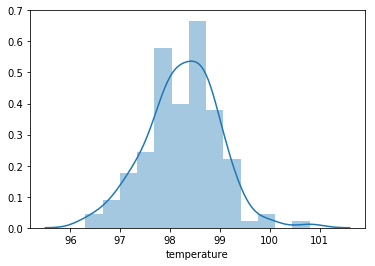

In [3]:
sns.distplot(df.temperature)

<function matplotlib.pyplot.show>

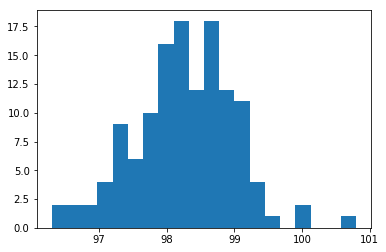

In [4]:
plt.hist(df.temperature, bins=20)
plt.show

In [5]:
# first recreate the ecdf function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

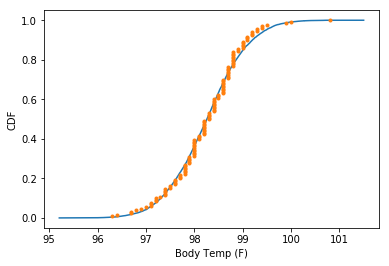

In [6]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, size=10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(df.temperature) 

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Body Temp (F)')
_ = plt.ylabel('CDF')
plt.show()

In [7]:
from statsmodels.graphics.gofplots import qqplot

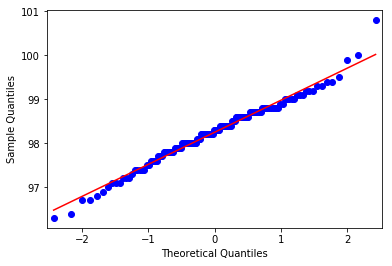

In [8]:
# looka at qq plot
qqplot(df.temperature, line='s')
plt.show()

In [9]:
from scipy.stats import shapiro

In [10]:
shapiro(df.temperature)

(0.9865769743919373, 0.2331680953502655)

In [11]:
# normality test
stat, p = shapiro(df.temperature)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.987, p=0.233
Sample looks Gaussian (fail to reject H0)


### 2.   Is the sample size large? Are the observations independent?
- Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


Sample size is not what I would consider "large", 130 measurements split between men and women. But it is probably large enough for what we are doing. Yes, the observations are independant

## Q3 - Is the true population mean really 98.6 degrees F?
1. First, try a bootstrap hypothesis test.
2. Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
3. In this situation, is it appropriate to use the  tt  or  zz  statistic?
4. Now try using the other test. How is the result be different? Why?

In [13]:
df.temperature.mean()

98.24923076923078

### Q3.1 - Use bootstrap mean to test if the population mean is 98.6 deg F, given the sample mean is 98.2 deg F

In [14]:
# create the bootstrap replicate function
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [15]:
# create a function which generates many bootstrap replicates from the data set. 
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

98.25034146153845


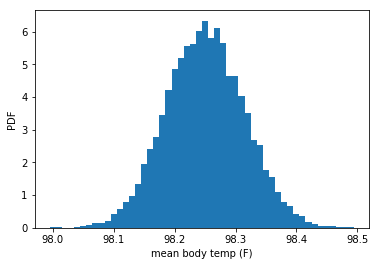

In [16]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(df.temperature, np.mean, size=10000)
print(np.mean(bs_replicates))

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('mean body temp (F)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

The histogram shows it is somewhat unlikely the mean body temp is 98.6 deg F

let's look at the 95% confidence interval

In [18]:
np.percentile(bs_replicates, [2.5, 97.5])

array([98.12536538, 98.37769231])

In [21]:
# Compute and print p-value: p
p = np.sum(bs_replicates <= 98.6 - df.temperature.mean())/ len(bs_replicates)
print('p-value =', p)

p-value = 0.0


### Q3.1 Answer - based on the 95% CI and p-value, the true mean is not 98.6

## Q3.2 - Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?

First I have no idea what frequentist statistical testing is...but:

### Q3.2 Answer - A one sample test is appropriate in this situation because we are comparing a sample mean to an established population mean

## Q3.3 - In this situation, is it appropriate to use the tt or zz statistic?

### Q3.3 Answer - The z-statistic is appropriate because the sample size is greater than 30
Here:
- Ho: Mean = 98.6
- Ha: Mean < 98.6

In [26]:
pop_mean = 98.6
sample_mean = df.temperature.mean()
sample_std = df.temperature.std()
sigma = sample_std/np.sqrt(len(df))

sample_mean, sample_std, sigma

(98.24923076923078, 0.7331831580389454, 0.06430441683789101)

In [27]:
# calculate the z-score, or how many std dev's the pop_mean is from the sample mean
z = (98.6 - sample_mean) / sigma
z

5.454823292364079

In [29]:
# Find the p-value
p = (1 - stats.norm.cdf(z))*2
print('The p-value using the z-statistic is: ', p)

The p-value using the z-statistic is:  4.902157013653152e-08


Reject the null hypothesis. Very, very low p-value

## Q3.4 - Now try using the other test. How is the result be different? Why?
Here:
- Ho: Mean = 98.6
- Ha: Mean != 98.6

In [25]:
one_sample_test = stats.ttest_1samp(df.temperature, popmean=98.6)
one_sample_test

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

Interesting, exactly the same as the t-statistic

Here again we reject Ho

## Q4 - Draw a small sample of size 10 from the data and repeat both frequentist tests.
1. Which one is the correct one to use?
2. What do you notice? What does this tell you about the difference in application of the  tt  and  zz  statistic?

In [32]:
n_10 = np.random.choice(df.temperature, size=10)
n_10

array([98.1, 97.9, 97.9, 99. , 98.8, 98.2, 98. , 99. , 97.7, 97.6])

In [34]:
small_sample_t = stats.ttest_1samp(n_10, popmean=98.6)
small_sample_t

Ttest_1sampResult(statistic=-2.291023432515676, pvalue=0.04769473744480711)

Here the p-value is considerably higher, yet still below the 0.05 threshold, still reject the null hypothesis

In [35]:
# using a z-statistic

small_sample_mean = n_10.mean()
small_sample_std = n_10.std()
small_sigma = small_sample_std/np.sqrt(len(n_10))

small_sample_mean, small_sample_std, small_sigma

(98.22, 0.49759421218498867, 0.1573531061021674)

In [36]:
# calculate the z-score, or how many std dev's the pop_mean is from the sample mean
z_small = (98.6 - small_sample_mean) / small_sigma
z_small

2.4149507398555334

In [38]:
# Find the p-value
p_small = (1 - stats.norm.cdf(z_small))*2
print('The p-value using the z-statistic is and small sample: ', p_small)

The p-value using the z-statistic is and small sample:  0.015737337877424817


## Q5 - At what temperature should we consider someone's temperature to be "abnormal"?
As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

In [39]:
# Using the bootstrap approach as before, look at the 95% confidence interval of the 10,000 replicates
np.percentile(bs_replicates, [2.5, 97.5])

array([98.12536538, 98.37769231])

In [40]:
# Using the "frequentist", or whatever that is method, I am considering abnormal anything outside +/- 3 std dev from the mean
upper_temp = sample_mean + 3*sample_std
lower_temp = sample_mean - 3*sample_std
print('Any temperature higher than ', upper_temp, ' or lower than ', lower_temp, ' can be considered abnormal.')

Any temperature higher than  100.44878024334761  or lower than  96.04968129511394  can be considered abnormal.


## Q6 - Is there a significant difference between males and females in normal temperature?
1. What testing approach did you use and why?
2. Write a story with your conclusion in the context of the original problem.

In [43]:
#Prepare the data for analysis, create male and female DataFrames
df_male = df[df.gender == 'M']
df_female = df[df.gender == 'F']

# create df's with only the temperature col
male_temperature = df_male.temperature
female_temperature = df_female.temperature

For hypothesis testing, the following are defined:

 - Null Hypothesis: Ho: mean temp men = mean temp women 
 - Alternate Hypothesis: Ha: mean temp men != mean temp women 

The threshold value of $\alpha$ is assumed to be 0.05.

In [44]:
# Use the bootstrap hypothesis test

# Compute the difference in mean sperm count: diff_means
diff_means = np.mean(female_temperature) - np.mean(male_temperature)

# Compute mean of pooled data: mean_count
mean_count = np.mean(df.temperature)

# Generate shifted data sets
female_shifted = female_temperature - np.mean(female_temperature) + mean_count
male_shifted = male_temperature - np.mean(male_temperature) + mean_count

# Generate bootstrap replicates
bs_reps_female = draw_bs_reps(female_shifted,
                               np.mean, size=10000)
bs_reps_male = draw_bs_reps(male_shifted,
                               np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_female - bs_reps_male

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(female_temperature) - np.mean(male_temperature)) \
            / len(bs_replicates)
print('p-value =', p)

p-value = 0.0112


Reject the null hypothesis, 0.0112 < 0.05, there is a significant difference between male and female body temperatures

## Conclusion:

1. The accepted average body temperature of 98.6 deg (F) is not supported by this sample of data
2. For this sample of data, depending on how confidence intervals are defined, 98.6 deg (F) could be considered "abnormal"
3. There is a significant difference between the average body temperatures of males and females in this data sample